# Contract machine

The dynamics equations were taken from this tutorial on system behavior:
- [Aircraft pitch: System modelling](https://ctms.engin.umich.edu/CTMS/index.php?example=AircraftPitch&section=SystemModeling)

In [1]:
# Activate the require environment
using Pkg
    # Use path relative to notebook
Pkg.activate("../../AlgebraicContracts.jl")

  Activating project at `~/Desktop/Categorical_Semantics/AlgebraicContracts.jl`


In [2]:
# Access submodule
using AlgebraicContracts.ContractedMachines

┌ Info: Precompiling AlgebraicContracts [7677e818-6541-44a4-9fd1-0e698382bac8]
└ @ Base loading.jl:1423


In [3]:
# Wiring diagrams
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
# Dynamics
using DifferentialEquations
using AlgebraicDynamics.DWDDynam
using LabelledArrays
# Plotting
using Plots
# Contracts
using IntervalSets  

### UAV Example

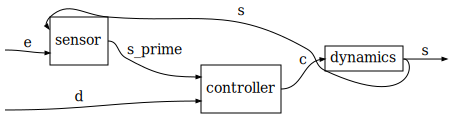

In [4]:
s = Box(:sensor    , [:s, :e]      , [:s_prime])
c = Box(:controller, [:s_prime, :d], [:c])
d = Box(:dynamics  , [:c]          , [:s])

# Diagram:           Inputs, Outputs <- Ports of entire diagram
UAV = WiringDiagram([:e,:d], [:s])

# Associate boxes to diagram
sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

add_wires!(UAV, [
  # Net Inputs      
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  # Connections
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  # Net Outputs
  (dynamics,1) => (output_id(UAV),1)
])

to_graphviz(UAV, orientation=LeftToRight, labels=true)

In [5]:
# State functions: 
equation_sensor(u, x, p, t)  = [ -p.λs*(u[1] - x[1] - x[2]) ];        # x = [θ, e] -> [Pitch angle, pitch offset]

equation_control(u, x, p, t) = [ -p.λc*(u[1] + p.kθ*x[1] - x[2]) ];   # x = [Sl, d] -> [sensor output, control input]

equation_dynamic(u, x, p, t) = [ -0.313*u[1] +  56.7*u[2] +  0.232*x[1],    # α -> Angle of attack
                                -0.0139*u[1] - 0.426*u[2] + 0.0203*x[1],    # q -> Angular velocity
                                                56.7*u[2]              ];   # θ -> Pitch angle    
                                                                            # x = [Sc] -> Controller output 

In [6]:
# Readout functions:  [select specific state]
readout_sensor(u, p, t)  = [ u[1] ];  # sl
readout_control(u, p, t) = [ u[1] ];  # sc
readout_dynamic(u, p ,t) = [ u[3] ];  # θ

In [7]:
# contract intervals                # variable in question:
sensor_in = [ -0.52..0.26, 
             -0.193..0.193 ]     # [s, e]
sensor_out = [ -0.52.. 0.26 ]              # [s_prime]

controller_in = [ -0.52..0.26, 
                 -0.193..0.193 ]     # [s_prime, d]

controller_out = [ -0.26..0.26 ]              # [c] 

dynamics_in = [ -0.26..0.26 ]                # [c]
dynamics_out = [ -0.52..0.26 ];              # [s]

In [8]:
# Machines for each box in diagram:
                                            # Inputs, States, Outputs
sensor_machine = ContractedMachine{Float64}( sensor_in, 1, sensor_out, 
                                            equation_sensor, readout_sensor );

controller_machine = ContractedMachine{Float64}( controller_in, 1, controller_out, 
                                            equation_control, readout_control ); 

dynamics_machine = ContractedMachine{Float64}( dynamics_in, 3, dynamics_out, 
                                            equation_dynamic, readout_dynamic ); 

In [9]:
# Output composition
comp = oapply( UAV, [sensor_machine, controller_machine, dynamics_machine] )

StaticContract( [-0.193,0.193] × [-0.193,0.193] × [-0.52,0.26] )[Machine]

In [10]:
# Initial values
x_init = LVector(e=0.00, d=0.1);                # Inputs: [e, d] -> [θ offset, 𝛿 control input]
u_init = LVector(sl=0, sc=0, α=0, q=0, θ=0);     # States: [sl, sc, α, q, θ]

# Integration interval
t_span = (0, 20); 

# Parameters:
param = (λs = 4, # Decay constant of sensor
         λc = 1, # Decay constant of controller
         kθ = 0);  # Gain of control input proportional to sensor output. Causes a feedback loop.

# solve system 
sol = solve( ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] );

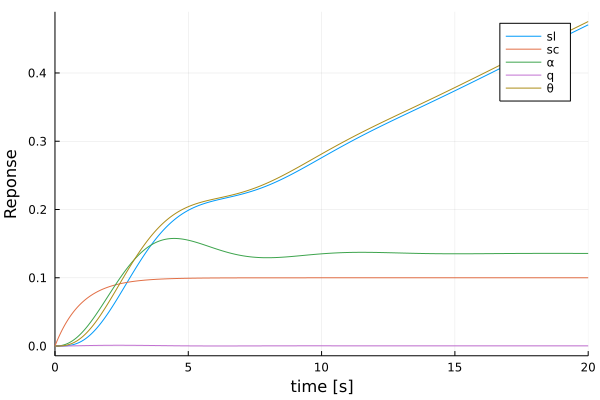

In [11]:
plot(sol, xlabel="time [s]", ylabel="Reponse")

In [12]:
dict = check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,"s_prime : 9.948479 , 20.000000",
dynamics,,"s : 9.948479 , 20.000000"
sensor,"s : 9.948479 , 20.000000","s_prime : 9.948479 , 20.000000"


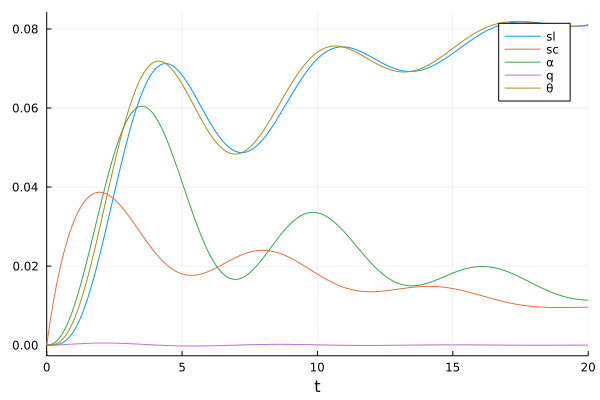

In [13]:
# Parameters:
param = (λs = 4, 
         λc = 1,
         kθ = 0.5);   
                     
x_init = LVector(e=0.0, d=0.05);       
      
# solve system 
sol = solve(ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] )
plot(sol)

In [14]:
dict = check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,,
dynamics,,
sensor,,
